Training data shape: (60000, 785)
Testing data shape: (10000, 785)

First few rows of training data:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0        

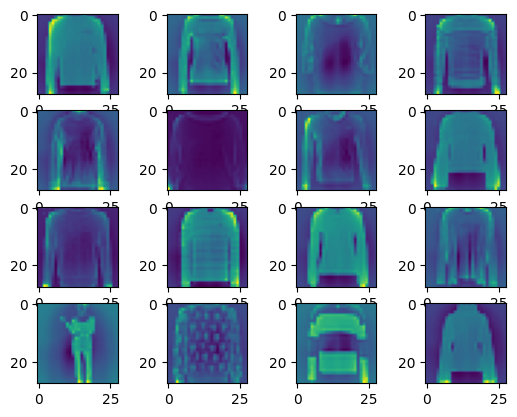

In [65]:
#Nikolaos Giannopoulos AM 5199
#Georgios Strouggis AM 5357

#All the imports happen here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#1 Dimensional Reduction

d = 784

#Load the data
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

#Make sure it got loaded correctly
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

#Print a few data form each data set
print("\nFirst few rows of training data:")
print(train_data.head())
print("\nFirst few rows of testing data:")
print(test_data.head())

#Initialize number of samples for each category
n = 1000

#Sample n images for each category from the training data
sampled_data_list = []
for label in train_data['label'].unique():
    sampled_data = train_data[train_data['label'] == label].sample(n=n, random_state=42)
    sampled_data_list.append(sampled_data)
train_data_sample = pd.concat(sampled_data_list).reset_index(drop=True)

#Split images and labels as X and Y
X_train = train_data_sample.drop(columns=['label'], axis=1).values
X_test = test_data.drop(columns=['label'], axis=1).values
Y_train = train_data_sample['label'].values
Y_test = test_data['label'].values

#Use Standard Scaler for the images
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Finalize Y
y_train = Y_train
y_test = Y_test

#Resize to 28x28
x_train = X_train_scaled.reshape((-1, 28, 28))
x_test = X_test_scaled.reshape((-1, 28, 28))

#View Train Data as pictures
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i], cmap='viridis')
plt.show()

Dimensionality: 132


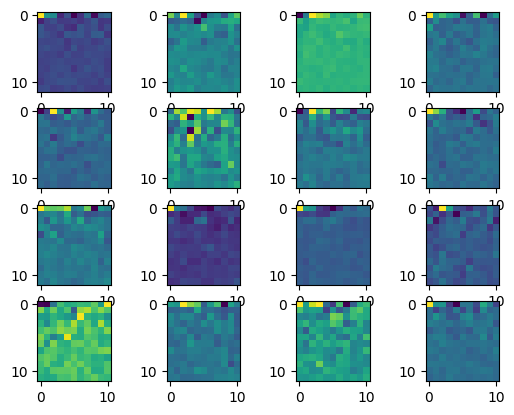

In [66]:
# Reduce dimensionality through PCA while keeping 90% covariance
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the dimensionality
M = X_train_pca.shape[1]
print(f"Dimensionality: {M}")

#Resize to 12x11. These dimensions were chosen because the square root of 132 is a floating point number, so instead we need to use values for its dimensions that are not equals, such as 12x11=132.
x_train_pca = X_train_pca.reshape((-1, 12, 11))
x_test_pca = X_test_pca.reshape((-1, 12, 11))

# View Train Data after PCA as pictures
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train_pca[i], cmap='viridis')
plt.show()

Epoch [1/20], Loss: 0.0309
Epoch [2/20], Loss: 0.0204
Epoch [3/20], Loss: 0.0163
Epoch [4/20], Loss: 0.0191
Epoch [5/20], Loss: 0.0170
Epoch [6/20], Loss: 0.0143
Epoch [7/20], Loss: 0.0157
Epoch [8/20], Loss: 0.0144
Epoch [9/20], Loss: 0.0131
Epoch [10/20], Loss: 0.0124
Epoch [11/20], Loss: 0.0133
Epoch [12/20], Loss: 0.0132
Epoch [13/20], Loss: 0.0109
Epoch [14/20], Loss: 0.0112
Epoch [15/20], Loss: 0.0116
Epoch [16/20], Loss: 0.0130
Epoch [17/20], Loss: 0.0120
Epoch [18/20], Loss: 0.0105
Epoch [19/20], Loss: 0.0102
Epoch [20/20], Loss: 0.0111


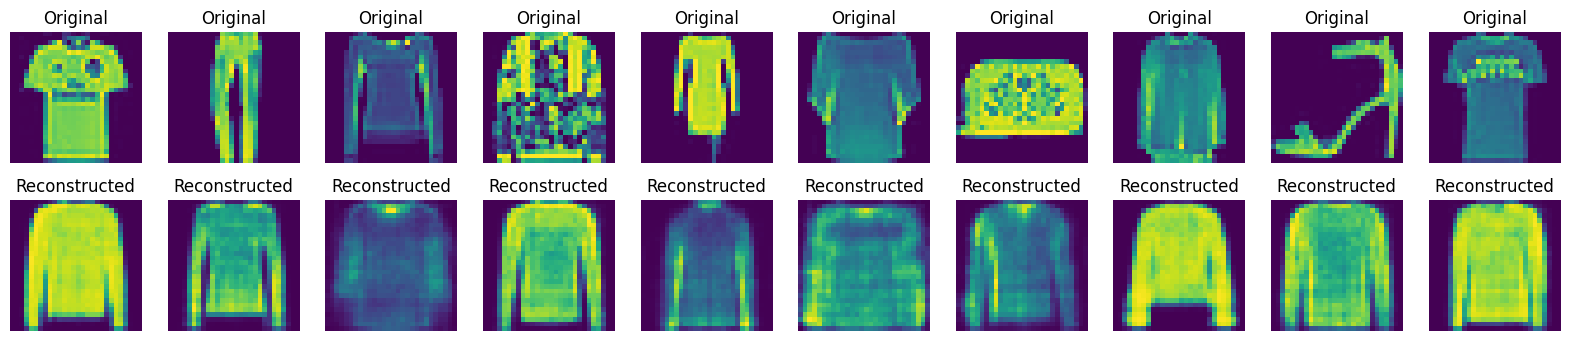

In [77]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( #Encoding
            nn.Linear(d, d//4),
            nn.ReLU(),
            nn.Linear(d//4, M),
            nn.ReLU()
        )
        self.decoder = nn.Sequential( #Decoding
            nn.Linear(M, d//4),
            nn.ReLU(),
            nn.Linear(d//4, d),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#Normalize data
X_train_new = X_train.astype(np.float32) / 255.0
X_test_new = X_test.astype(np.float32) / 255.0

#Transform to tensors
x_train_torch = t.tensor(X_train_new, dtype=t.float32)
x_test_torch = t.tensor(X_test_new, dtype=t.float32)

#Create DataLoader. Last time we did it hard coded and had many challenges. Datasets and Loader seem to be more efficient
#Batch size 50 like last time
train_dataset = TensorDataset(x_train_torch, x_test_torch)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

#Model, criterion and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Set number of epochs, the more epochs, the better the outcome
#epochs = 5
#epochs = 10
#epochs = 20
epochs = 20

#Start of training loop
for epoch in range(epochs):
    for data in train_loader:
        inputs, _ = data

        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
#Encode and decode images
model.eval()
with t.no_grad():
    encoded_data = model.encoder(x_train_torch)
    decoded_data = model.decoder(encoded_data).numpy()

#Visualize original and reconstructed images
r = 10
plt.figure(figsize=(20, 4))
for i in range(r):
    #Display original
    plot = plt.subplot(2, r, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='viridis')
    plt.title("Original")
    plt.axis('off')

    #Display reconstructed
    plot = plt.subplot(2, r, i + 1 + r)
    plt.imshow(decoded_data[i].reshape(28, 28), cmap='viridis')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

In [68]:
#Second best from last exercise because best didnt work well here
#First we need the data to be encoded so we use them
autoencoder = Autoencoder()
autoencoder.eval()
with t.no_grad():
    train_tensor_encoded = autoencoder.encoder(t.tensor(X_train_scaled, dtype=t.float32))
    test_tensor_encoded = autoencoder.encoder(t.tensor(X_test_scaled, dtype=t.float32))

#We save them on the array, although they are not array just to differentiate them
x_train_array = train_tensor_encoded.numpy()
x_test_array = test_tensor_encoded.numpy()

#Create and train the Random Forest with the 100 estimators
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train_array, y_train)
#Forest accuracy
accuracy = random_forest.score(x_test_array, y_test)
print(f"Accuracy with Random Forest on Autoencoder: {accuracy}\n")

#Create and train the Random Forest with the 100 estimators
random_forest2 = RandomForestClassifier(n_estimators=100)
random_forest2.fit(X_train_pca, y_train)
#Forest accuracy
accuracy = random_forest2.score(X_test_pca, y_test)
print(f"Accuracy with Random Forest on PCA: {accuracy}\n")

Accuracy with Random Forest on Autoencoder: 0.7866

Accuracy with Random Forest on PCA: 0.844



Cluster: 10, Score: 0.14499206880503232
Cluster: 11, Score: 0.13690443393744267
Cluster: 12, Score: 0.12817653646244848
Cluster: 13, Score: 0.12432353839492515
Cluster: 14, Score: 0.12927195070800737
Cluster: 15, Score: 0.12390516550356093
Cluster: 16, Score: 0.12606859130695072
Cluster: 17, Score: 0.1174121167698086
Cluster: 18, Score: 0.12059334246566314
Cluster: 19, Score: 0.11255401244182249
Cluster: 20, Score: 0.1159470863352774
Optimal number of clusters: 10 with a score of 0.14499206880503232


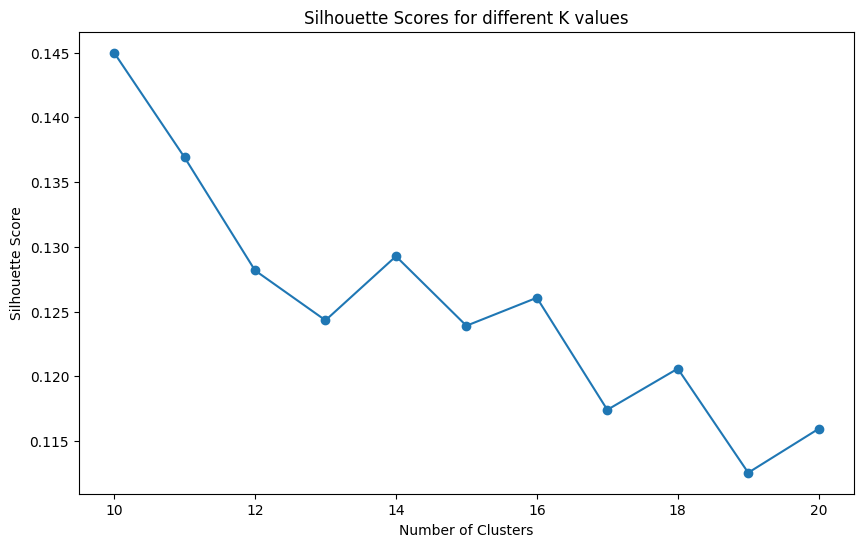

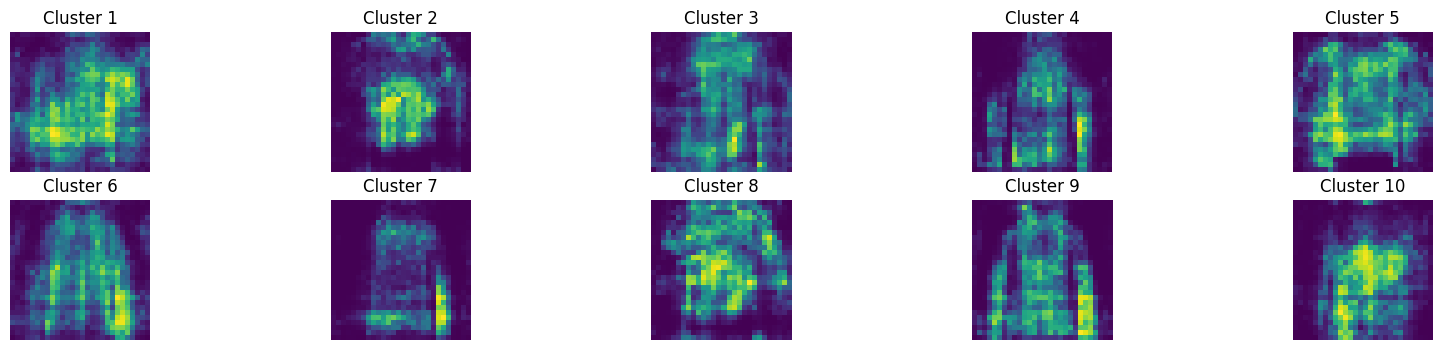

In [69]:
#2 Clustering
#k-means for PCA
silhouette_scores = []
k_list = []

#Loop for k values with random_state equals 42 after research on which should be
for k in range(10, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, cluster_labels, metric='euclidean')
    silhouette_scores.append(score)
    k_list.append(kmeans)
    print(f'Cluster: {k}, Score: {score}')

#Best value for k and score
k_best = k_list[np.argmax(silhouette_scores)]
k_best_score = 0
k_best_pos = 0
kmeans_best = 0
for i in range(10):
    if silhouette_scores[i] > k_best_score:
        k_best_score = silhouette_scores[i]
        k_best_pos = i + 10
        kmeans_best = k_list[i]
print(f"Optimal number of clusters: {k_best_pos} with a score of {k_best_score}")
center = k_best.cluster_centers_

#Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(10, 21), silhouette_scores, marker='o')
plt.title('Silhouette Scores for different K values')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


#Decode the center and reconstruct the images to their original dimensions
center_tensor = t.tensor(center, dtype=t.float32)
with t.no_grad():
    reconstructed_center = model.decoder(center_tensor).numpy()

#Plot the centers
plt.figure(figsize=(20, 4))
for j in range(k_best_pos):
    plt.subplot(2, k_best_pos // 2, j + 1)
    plt.imshow(reconstructed_center[j].reshape(28, 28), cmap='viridis')
    plt.title(f'Cluster {j+1}')
    plt.axis('off')
plt.show()


In [70]:


#Encode labels
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)

cluster_labels = kmeans_best.predict(X_train_pca)
num_clusters = len(np.unique(cluster_labels))

#Empty majority class array
majority_classes = np.zeros(num_clusters, dtype=int)

#Purity
purity = 0
for cluster in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_labels_true = Y_test_encoded[cluster_indices]
    if len(cluster_labels_true) > 0:
        majority_class = np.argmax(np.bincount(cluster_labels_true))
        purity += np.sum(cluster_labels_true == majority_class)

purity /= len(Y_test)
print(f'Purity: {purity}')


#We set the loop
f_measures = []
total_samples = len(y_train)
#Loop start for each cluster
for cluster in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_labels_true = y_train[cluster_indices]
    #Calculate TP, FP and FN
    if len(cluster_labels_true) > 0:
        majority_class = np.argmax(np.bincount(cluster_labels_true))
        TP = np.sum(cluster_labels_true == majority_class)
        FP = len(cluster_labels_true) - TP
        FN = np.sum(y_train == majority_class) - TP
        
        #Calculate precision recall and f-measure and save final results
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f_measure = (1 + TP) * (precision * recall) / (TP * precision + recall) if (TP * precision + recall) > 0 else 0
        weighted_f_measure = f_measure * (len(cluster_labels_true) / total_samples)
        f_measures.append(weighted_f_measure)

#Calculate total and print final results
f_measure_total = np.sum(f_measures)
print(f'F-measure: {f_measure_total}')

Purity: 0.1171
F-measure: 0.6086535564197009


Cluster: 10, Score: 0.16615453362464905
Cluster: 11, Score: 0.16726244986057281
Cluster: 12, Score: 0.17453055083751678
Cluster: 13, Score: 0.164167121052742
Cluster: 14, Score: 0.16092604398727417
Cluster: 15, Score: 0.15966250002384186
Cluster: 16, Score: 0.15278993546962738
Cluster: 17, Score: 0.15117307007312775
Cluster: 18, Score: 0.14720852673053741
Cluster: 19, Score: 0.1514328569173813
Cluster: 20, Score: 0.15288224816322327
Optimal number of clusters: 12 with a score of 0.17453055083751678


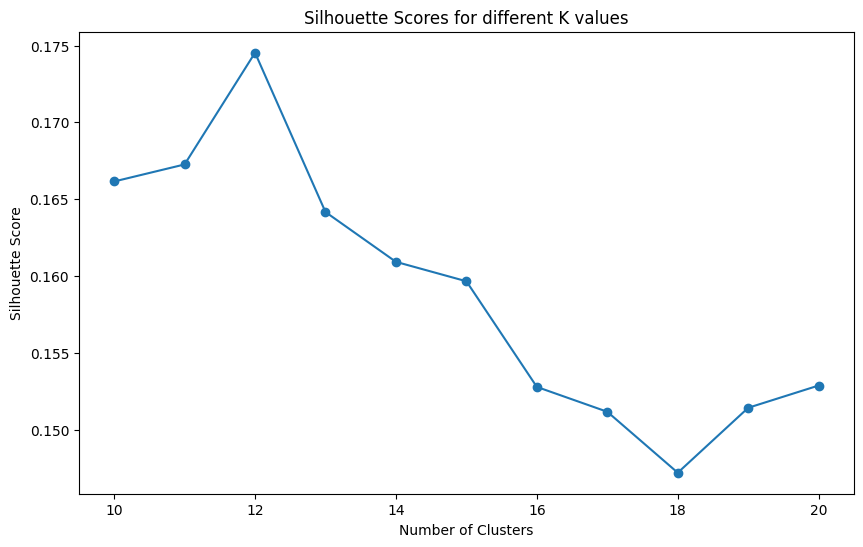

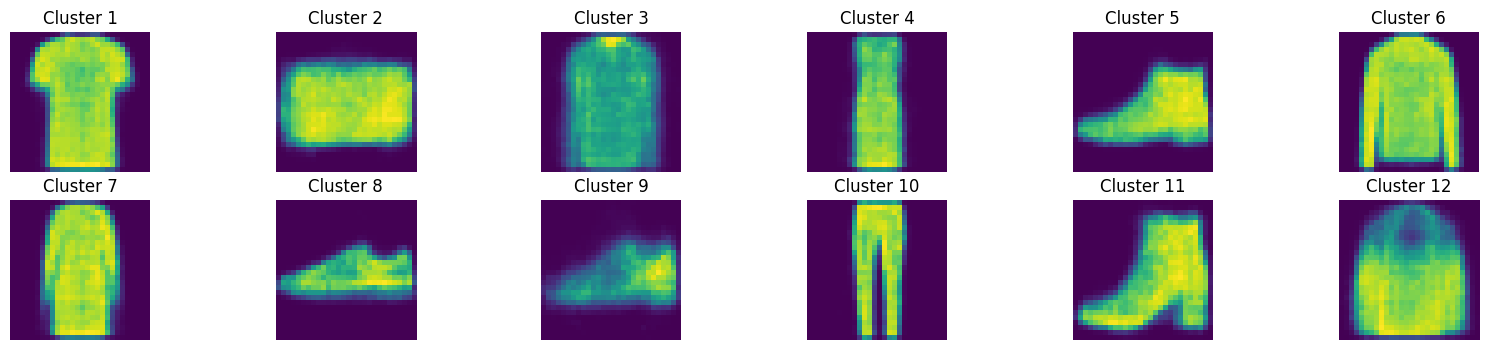

In [78]:
#k-means for Autoencoder
silhouette_scores = []
k_list = []


for k in range(10, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(encoded_data)
    score = silhouette_score(encoded_data, cluster_labels, metric='euclidean')
    silhouette_scores.append(score)
    k_list.append(kmeans)
    print(f'Cluster: {k}, Score: {score}')

#Best value for k and score
k_best = k_list[np.argmax(silhouette_scores)]
k_best_score = 0
k_best_pos = 0
kmeans_best = 0
for i in range(10):
    if silhouette_scores[i] > k_best_score:
        k_best_score = silhouette_scores[i]
        k_best_pos = i + 10
        kmeans_best = k_list[i]
print(f"Optimal number of clusters: {k_best_pos} with a score of {k_best_score}")
center = k_best.cluster_centers_

#Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(10, 21), silhouette_scores, marker='o')
plt.title('Silhouette Scores for different K values')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


#Decode the center and reconstruct the images to their original dimensions
center_tensor = t.tensor(center, dtype=t.float32)
with t.no_grad():
    reconstructed_center = model.decoder(center_tensor).numpy()

#Plot the centers
plt.figure(figsize=(20, 4))
for j in range(k_best_pos):
    plt.subplot(2, k_best_pos // 2, j + 1)
    plt.imshow(reconstructed_center[j].reshape(28, 28), cmap='viridis')
    plt.title(f'Cluster {j+1}')
    plt.axis('off')
plt.show()




In [75]:

#Encode labels
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)

cluster_labels = kmeans_best.predict(encoded_data)
num_clusters = len(np.unique(cluster_labels))

#Empty majority class array
majority_classes = np.zeros(num_clusters, dtype=int)

#Purity
purity = 0
for cluster in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_labels_true = Y_test_encoded[cluster_indices]
    if len(cluster_labels_true) > 0:
        majority_class = np.argmax(np.bincount(cluster_labels_true))
        purity += np.sum(cluster_labels_true == majority_class)

purity /= len(Y_test)
print(f'Purity: {purity}')



#We set the loop
f_measures = []
total_samples = len(y_train)
#Loop start for each cluster
for cluster in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_labels_true = y_train[cluster_indices]
    #Calculate TP, FP and FN
    if len(cluster_labels_true) > 0:
        majority_class = np.argmax(np.bincount(cluster_labels_true))
        TP = np.sum(cluster_labels_true == majority_class)
        FP = len(cluster_labels_true) - TP
        FN = np.sum(y_train == majority_class) - TP
        
        #Calculate precision recall and f-measure and save final results
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f_measure = (1 + TP) * (precision * recall) / (TP * precision + recall) if (TP * precision + recall) > 0 else 0
        weighted_f_measure = f_measure * (len(cluster_labels_true) / total_samples)
        f_measures.append(weighted_f_measure)

#Calculate total and print final results
f_measure_total = np.sum(f_measures)
print(f'F-measure: {f_measure_total}')

Purity: 0.1142
F-measure: 0.4890031490779642
